In [8]:
import gymnasium as gym
import numpy as np
from stable_baselines3.common.env_util import make_vec_env as make_vec_env_sb3
from copy import deepcopy
import torch
from torch.distributions import Normal
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.utils.data import Dataset, DataLoader
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
import imageio
import pandas as pd
from tqdm import tqdm
from PIL import Image
from stable_baselines3.dqn.policies import MlpPolicy
import matplotlib.pyplot as plt


In [9]:
import gc
gc.collect()

499

In [10]:
!nvidia-smi
# clean up memory forcefully
torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device



Sat Sep 14 14:55:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti     On  | 00000000:01:00.0 Off |                  N/A |
| 19%   55C    P2              59W / 250W |   1186MiB / 11264MiB |      9%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

device(type='cuda')

In [11]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
class CustomDataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.tensor(observations, dtype=torch.float32,device=device)
        self.actions = torch.tensor(actions, dtype=torch.float32,device=device)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

class PolicyNetwork(nn.Module):
    def __init__(self,  output_dim):
        super(PolicyNetwork, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(3136, 512)
        self.fc2 = nn.Linear(512, output_dim)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc1(x.view(x.size(0), -1)))
        x = self.fc2(x)
        return x

    

Using device: cuda


In [12]:
from stable_baselines3.common.env_util import make_atari_env
env_id="MsPacmanNoFrameskip-v4"
#env = make_vec_env_sb3(env_id, n_envs=1)
observations= np.load("../dataset/obs.npy", allow_pickle=True)
actions = np.load("../dataset/actions.npy", allow_pickle=True)
rewards = np.load("../dataset/rewards.npy", allow_pickle=True)
dones = np.load("../dataset/dones.npy", allow_pickle=True)
info = np.load("../dataset/info.npy", allow_pickle=True)
next_obs = np.load("../dataset/next_obs.npy", allow_pickle=True)
observations=observations.squeeze()
actions=actions.squeeze()
rewards=rewards.squeeze()
dones=dones.squeeze()
info=info.squeeze()
next_obs=next_obs.squeeze()
# observations = observations[:1000]
# actions = actions[:1000]
print(observations.shape, actions.shape, rewards.shape, dones.shape, info.shape, next_obs.shape)
# print(observations[0], actions[0], rewards[0], dones[0], info[0], next_obs[0])
env = make_atari_env(env_id, n_envs=1,wrapper_kwargs={"clip_reward":False})
from stable_baselines3.common.vec_env import VecFrameStack, VecTransposeImage
env = VecTransposeImage(env)            # 确保图像通道在前
env = VecFrameStack(env, n_stack=4)     # 堆叠4帧
obs = env.reset()
print(obs.shape)
# print(env.action_space.n)
# print(env.observation_space.shape[0])

(1154, 4, 84, 84) (1154,) (1154,) (1154,) (1154,) (1154, 4, 84, 84)
(1, 4, 84, 84)


In [13]:
mean=observations.mean(axis=0)
std=observations.std(axis=0)
print(mean.shape, std.shape)
print(mean, std)

(4, 84, 84) (4, 84, 84)
[[[ 87.31369151  87.31369151  66.47746967 ...  66.47746967  87.31369151
    87.31369151]
  [144.86135182 144.86135182  42.66464471 ...  42.66464471 144.86135182
   144.86135182]
  [144.86135182 144.86135182  42.66464471 ...  42.66464471 144.86135182
   144.86135182]
  ...
  [  0.           0.           0.         ...   0.           0.
     0.        ]
  [  0.           0.           0.         ...   0.           0.
     0.        ]
  [  0.           0.           0.         ...   0.           0.
     0.        ]]

 [[ 87.54246101  87.54246101  66.65164645 ...  66.65164645  87.54246101
    87.54246101]
  [145.24090121 145.24090121  42.77642981 ...  42.77642981 145.24090121
   145.24090121]
  [145.24090121 145.24090121  42.77642981 ...  42.77642981 145.24090121
   145.24090121]
  ...
  [  0.           0.           0.         ...   0.           0.
     0.        ]
  [  0.           0.           0.         ...   0.           0.
     0.        ]
  [  0.           0.   

In [14]:
# 导入IPython显示控制模块

from tqdm import tqdm
policy_network = PolicyNetwork(env.action_space.n).to(device)
# nn init kaiming
torch.nn.init.kaiming_normal_(policy_network.conv1.weight)
torch.nn.init.kaiming_normal_(policy_network.conv2.weight)
torch.nn.init.kaiming_normal_(policy_network.conv3.weight)
torch.nn.init.kaiming_normal_(policy_network.fc1.weight)
torch.nn.init.kaiming_normal_(policy_network.fc2.weight)

# prev = PolicyNetwork(env.action_space.n).to(device)
# prev.load_state_dict(policy_network.state_dict())
# prev.eval()

# optimizer = torch.optim.Adam(policy_network.parameters(), lr=3e-4,weight_decay=1e-3)
optimizer = torch.optim.Adam(policy_network.parameters(), lr=3e-5)

# Training loop
num_epochs = 100000
batch_size = observations.shape[0]
mean=observations.mean()
std=observations.std()
print(mean.shape, std.shape)

Normlization=True
# dataset = mydataset(observations=observations, actions=actions)
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
normalize_obs= (observations-mean)/std
loss_graph=[]
eval_rewards=[]
margin_graph=[]
positive_reward_graph=[]
negative_reward_graph=[]
num_test = 1
if Normlization:
    obs_batch = torch.tensor(np.array(normalize_obs), dtype=torch.float32).to(device)
else:
    obs_batch = torch.tensor(np.array(observations), dtype=torch.float32).to(device)
act_batch = torch.tensor(np.array(actions), dtype=torch.float32).to(device)
test_score=0
for epoch in tqdm(range(1,1+num_epochs)):
    policy_network.train()

    # for step, (obs_batch,act_batch) in enumerate(pbar):
    


    
    logits = policy_network(obs_batch)
    model_dist = Categorical(logits=logits)
    model_act_sample = model_dist.sample()
    policy_chosen_logps = model_dist.log_prob(act_batch)
    policy_rejected_logps = model_dist.log_prob(model_act_sample)
        # with torch.no_grad():
        #     prev_dist = Categorical(logits=prev(obs_batch))
        #     reference_chosen_logps = prev_dist.log_prob(act_batch)
        #     reference_rejected_logps = prev_dist.log_prob(model_act_sample)


    pi_logratios = policy_chosen_logps - policy_rejected_logps
        # ref_logratios = reference_chosen_logps - reference_rejected_logps

    logits = pi_logratios

    chosen_logratios = policy_chosen_logps 
    reject_logratios = policy_rejected_logps


    beta = 0.5
    # losses = (-F.logsigmoid(beta * logits))-policy_chosen_logps
    losses = (-F.logsigmoid(beta * logits))
    # losses = -policy_chosen_logps
    loss = losses.mean()
    # Optimize the policy
    optimizer.zero_grad()



    loss.backward()

    optimizer.step()
    # pbar.set_description((f"Epoch [{epoch+1}/{num_epochs}]"))
    positive_reward = chosen_logratios.detach().mean().item()
    negative_reward = reject_logratios.detach().mean().item()
    margin = positive_reward - negative_reward
    loss_graph.append(loss.detach().item())
    margin_graph.append(margin)
    positive_reward_graph.append(positive_reward)
    negative_reward_graph.append(negative_reward)
    # pbar.set_postfix({"loss":loss.detach().item(), "positive_reward": positive_reward, "negative_reward": negative_reward, "margin": positive_reward - negative_reward, "test_score": test_score})

    if epoch % 500 == 0:
        total_reward=0

        policy_network.eval()  # 切换到评估模式


        total_reward=0
        # test the policy and save as the first test as gif
        frames = []
        saved_frame = False
        for _ in range(num_test):
            state = env.reset()
            done = False
            while not done:
                if Normlization:
                    state_tensor = torch.tensor((state-mean)/std, dtype=torch.float32).to(device)
                else:
                    state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
                with torch.no_grad():
                    action = Categorical(logits=(policy_network(state_tensor))).sample().cpu().numpy()
                    
                state, reward, done, _ = env.step(action)  # 执行动作
                total_reward += reward
                if not saved_frame:
                    frame = env.render(mode="rgb_array")
                    frames.append(frame)  # 添加到帧列表中
            done = False
            while not done:
                if Normlization:
                    state_tensor = torch.tensor((state-mean)/std, dtype=torch.float32).to(device)
                else:
                    state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
                with torch.no_grad():
                    action = Categorical(logits=(policy_network(state_tensor))).sample().cpu().numpy()
                    
                state, reward, done, _ = env.step(action)  # 执行动作
                total_reward += reward
                if not saved_frame:
                    frame = env.render(mode="rgb_array")
                    frames.append(frame)  # 添加到帧列表中
            done = False
            while not done:
                if Normlization:
                    state_tensor = torch.tensor((state-mean)/std, dtype=torch.float32).to(device)
                else:
                    state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
                with torch.no_grad():
                    action = Categorical(logits=(policy_network(state_tensor))).sample().cpu().numpy()
                    
                state, reward, done, _ = env.step(action)  # 执行动作
                total_reward += reward
                if not saved_frame:
                    frame = env.render(mode="rgb_array")
                    frames.append(frame)  # 添加到帧列表中
                # 保存为GIF
            if not saved_frame:
                saved_frame = True
                image_path = f"test_{epoch}.gif"
                imageio.mimsave("./gif/"+image_path, frames, duration=40)
        # print(total_reward/num_test)
        test_score = total_reward/num_test
        eval_rewards.append(total_reward/num_test)
        policy_network.train()  # 切换回训练模式
        print(f"Epoch [{epoch}/{num_epochs}] loss: {loss.detach().item()} positive_reward: {positive_reward} negative_reward: {negative_reward} margin: {positive_reward - negative_reward} test_score: {test_score}")


    



() ()


  0%|          | 50/100000 [00:01<34:59, 47.62it/s]

  0%|          | 495/100000 [00:10<34:54, 47.51it/s]/mnt/nfs/work/c98181/miniconda3/envs/copy/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(
  1%|          | 505/100000 [00:13<4:00:54,  6.88it/s]

Epoch [500/100000] loss: 0.59171062707901 positive_reward: -0.6093464493751526 negative_reward: -1.18588387966156 margin: 0.5765374302864075 test_score: [210.]


  1%|          | 1005/100000 [00:29<7:18:25,  3.76it/s] 

Epoch [1000/100000] loss: 0.6156864762306213 positive_reward: -0.30005761981010437 negative_reward: -0.7620523571968079 margin: 0.4619947373867035 test_score: [1460.]


  2%|▏         | 1505/100000 [00:42<3:20:52,  8.17it/s]

Epoch [1500/100000] loss: 0.630521833896637 positive_reward: -0.17956724762916565 negative_reward: -0.577065646648407 margin: 0.39749839901924133 test_score: [190.]


  2%|▏         | 2005/100000 [00:56<4:27:22,  6.11it/s]

Epoch [2000/100000] loss: 0.649876594543457 positive_reward: -0.12381129711866379 negative_reward: -0.3976050615310669 margin: 0.2737937644124031 test_score: [1860.]


  3%|▎         | 2505/100000 [01:12<6:15:51,  4.32it/s]

Epoch [2500/100000] loss: 0.6640034317970276 positive_reward: -0.09230312705039978 negative_reward: -0.272366464138031 margin: 0.18006333708763123 test_score: [540.]


  3%|▎         | 3005/100000 [01:28<7:33:09,  3.57it/s] 

Epoch [3000/100000] loss: 0.665516197681427 positive_reward: -0.07286185771226883 negative_reward: -0.25670894980430603 margin: 0.1838470920920372 test_score: [2050.]


  4%|▎         | 3505/100000 [01:44<6:18:52,  4.24it/s]

Epoch [3500/100000] loss: 0.6688572764396667 positive_reward: -0.05675841122865677 negative_reward: -0.23282289505004883 margin: 0.17606448382139206 test_score: [1900.]


  4%|▍         | 4005/100000 [02:00<6:39:48,  4.00it/s]

Epoch [4000/100000] loss: 0.676611602306366 positive_reward: -0.049616869539022446 negative_reward: -0.15814286470413208 margin: 0.10852599516510963 test_score: [1630.]


  5%|▍         | 4505/100000 [02:14<4:18:56,  6.15it/s]

Epoch [4500/100000] loss: 0.6771503686904907 positive_reward: -0.039503563195466995 negative_reward: -0.15405848622322083 margin: 0.11455492302775383 test_score: [470.]


  5%|▌         | 5005/100000 [02:29<5:36:20,  4.71it/s]

Epoch [5000/100000] loss: 0.6818808317184448 positive_reward: -0.030801868066191673 negative_reward: -0.10859489440917969 margin: 0.07779302634298801 test_score: [1790.]


  6%|▌         | 5505/100000 [02:43<4:43:31,  5.55it/s]

Epoch [5500/100000] loss: 0.6784757971763611 positive_reward: -0.02652343176305294 negative_reward: -0.13228319585323334 margin: 0.1057597640901804 test_score: [1580.]


  6%|▌         | 6005/100000 [02:58<5:08:26,  5.08it/s]

Epoch [6000/100000] loss: 0.6775043606758118 positive_reward: -0.024769321084022522 negative_reward: -0.14064432680606842 margin: 0.1158750057220459 test_score: [1140.]


  7%|▋         | 6505/100000 [03:12<4:35:01,  5.67it/s]

Epoch [6500/100000] loss: 0.6823428869247437 positive_reward: -0.019724614918231964 negative_reward: -0.09621556103229523 margin: 0.07649094611406326 test_score: [1160.]


  7%|▋         | 7005/100000 [03:27<5:27:52,  4.73it/s]

Epoch [7000/100000] loss: 0.6842613220214844 positive_reward: -0.016696186736226082 negative_reward: -0.08798812329769135 margin: 0.07129193656146526 test_score: [1700.]


  8%|▊         | 7505/100000 [03:41<4:00:11,  6.42it/s]

Epoch [7500/100000] loss: 0.6881763339042664 positive_reward: -0.013559326529502869 negative_reward: -0.04749014973640442 margin: 0.03393082320690155 test_score: [410.]


  8%|▊         | 8006/100000 [03:54<3:36:44,  7.07it/s]

Epoch [8000/100000] loss: 0.6882764101028442 positive_reward: -0.013357013463973999 negative_reward: -0.04795638471841812 margin: 0.03459937125444412 test_score: [360.]


  9%|▊         | 8506/100000 [04:10<5:28:52,  4.64it/s]

Epoch [8500/100000] loss: 0.6873830556869507 positive_reward: -0.016323575749993324 negative_reward: -0.05381564050912857 margin: 0.037492064759135246 test_score: [1160.]


  9%|▉         | 9006/100000 [04:24<4:20:20,  5.83it/s]

Epoch [9000/100000] loss: 0.6885082125663757 positive_reward: -0.010936621576547623 negative_reward: -0.046739786863327026 margin: 0.035803165286779404 test_score: [1100.]


 10%|▉         | 9506/100000 [04:42<8:19:38,  3.02it/s] 

Epoch [9500/100000] loss: 0.6879687905311584 positive_reward: -0.007545020896941423 negative_reward: -0.051224324852228165 margin: 0.04367930395528674 test_score: [3240.]


 10%|█         | 10006/100000 [04:56<4:27:15,  5.61it/s]

Epoch [10000/100000] loss: 0.6901680827140808 positive_reward: -0.007522626779973507 negative_reward: -0.030252255499362946 margin: 0.02272962871938944 test_score: [1100.]


 11%|█         | 10507/100000 [05:09<3:49:15,  6.51it/s]

Epoch [10500/100000] loss: 0.6908125877380371 positive_reward: -0.0071442220360040665 negative_reward: -0.023959197103977203 margin: 0.016814975067973137 test_score: [430.]


 11%|█         | 11007/100000 [05:22<3:01:58,  8.15it/s]

Epoch [11000/100000] loss: 0.689958930015564 positive_reward: -0.005464429501444101 negative_reward: -0.036741163581609726 margin: 0.031276734080165625 test_score: [170.]


 12%|█▏        | 11507/100000 [05:38<5:32:38,  4.43it/s]

Epoch [11500/100000] loss: 0.6905571818351746 positive_reward: -0.0049286531284451485 negative_reward: -0.030681289732456207 margin: 0.02575263660401106 test_score: [1900.]


 12%|█▏        | 12008/100000 [05:51<3:14:16,  7.55it/s]

Epoch [12000/100000] loss: 0.6879265308380127 positive_reward: -0.0046422481536865234 negative_reward: -0.04973360523581505 margin: 0.045091357082128525 test_score: [280.]


 13%|█▎        | 12508/100000 [06:04<3:55:34,  6.19it/s]

Epoch [12500/100000] loss: 0.690410315990448 positive_reward: -0.0035809692926704884 negative_reward: -0.028648819774389267 margin: 0.02506785048171878 test_score: [1090.]


 13%|█▎        | 13008/100000 [06:18<4:08:57,  5.82it/s]

Epoch [13000/100000] loss: 0.6920617818832397 positive_reward: -0.003748679766431451 negative_reward: -0.013196681626141071 margin: 0.00944800185970962 test_score: [480.]


 14%|█▎        | 13508/100000 [06:33<4:53:53,  4.90it/s]

Epoch [13500/100000] loss: 0.6908726096153259 positive_reward: -0.0050103324465453625 negative_reward: -0.02118665724992752 margin: 0.01617632480338216 test_score: [1310.]


 14%|█▍        | 14008/100000 [06:47<3:49:59,  6.23it/s]

Epoch [14000/100000] loss: 0.6910430788993835 positive_reward: -0.003493686206638813 negative_reward: -0.021553970873355865 margin: 0.018060284666717052 test_score: [1160.]


 15%|█▍        | 14508/100000 [07:02<5:06:26,  4.65it/s]

Epoch [14500/100000] loss: 0.6904430389404297 positive_reward: -0.0027697875630110502 negative_reward: -0.025850795209407806 margin: 0.023081007646396756 test_score: [480.]


 15%|█▌        | 15008/100000 [07:17<4:23:14,  5.38it/s]

Epoch [15000/100000] loss: 0.687743604183197 positive_reward: -0.007028371561318636 negative_reward: -0.05124099925160408 margin: 0.044212627690285444 test_score: [1310.]


 16%|█▌        | 15508/100000 [07:30<3:07:09,  7.52it/s]

Epoch [15500/100000] loss: 0.6873466372489929 positive_reward: -0.005259924102574587 negative_reward: -0.0546274408698082 margin: 0.04936751676723361 test_score: [300.]


 16%|█▌        | 16008/100000 [07:43<3:15:33,  7.16it/s]

Epoch [16000/100000] loss: 0.6921732425689697 positive_reward: -0.003975720144808292 negative_reward: -0.011269385926425457 margin: 0.007293665781617165 test_score: [320.]


 17%|█▋        | 16508/100000 [07:57<3:51:58,  6.00it/s]

Epoch [16500/100000] loss: 0.6931471824645996 positive_reward: -0.0032202478032559156 negative_reward: -0.0032202478032559156 margin: 0.0 test_score: [1090.]


 17%|█▋        | 17008/100000 [08:11<3:44:02,  6.17it/s]

Epoch [17000/100000] loss: 0.692031979560852 positive_reward: -0.002739416668191552 negative_reward: -0.013072430156171322 margin: 0.01033301348797977 test_score: [1090.]


 18%|█▊        | 17508/100000 [08:25<4:17:42,  5.34it/s]

Epoch [17500/100000] loss: 0.6886287927627563 positive_reward: -0.0024056024849414825 negative_reward: -0.046766333281993866 margin: 0.04436073079705238 test_score: [440.]


 18%|█▊        | 18008/100000 [08:38<2:57:46,  7.69it/s]

Epoch [18000/100000] loss: 0.6904118657112122 positive_reward: -0.002184129087254405 negative_reward: -0.027529709041118622 margin: 0.025345579953864217 test_score: [240.]


 19%|█▊        | 18508/100000 [08:55<6:39:07,  3.40it/s]

Epoch [18500/100000] loss: 0.6925711631774902 positive_reward: -0.002067913068458438 negative_reward: -0.008214768953621387 margin: 0.0061468558851629496 test_score: [3240.]


 19%|█▉        | 19009/100000 [09:08<3:13:30,  6.98it/s]

Epoch [19000/100000] loss: 0.6926215291023254 positive_reward: -0.0021708577405661345 negative_reward: -0.006336244288831949 margin: 0.004165386548265815 test_score: [380.]


 20%|█▉        | 19509/100000 [09:25<6:25:49,  3.48it/s]

Epoch [19500/100000] loss: 0.6931471824645996 positive_reward: -0.001739688334055245 negative_reward: -0.001739688334055245 margin: 0.0 test_score: [3180.]


 20%|██        | 20004/100000 [09:42<9:12:39,  2.41it/s]

Epoch [20000/100000] loss: 0.6926018595695496 positive_reward: -0.0017798752523958683 negative_reward: -0.006494549103081226 margin: 0.004714673850685358 test_score: [3240.]


 21%|██        | 20509/100000 [09:59<6:24:23,  3.45it/s]

Epoch [20500/100000] loss: 0.6925681233406067 positive_reward: -0.0015965210041031241 negative_reward: -0.00797305442392826 margin: 0.006376533419825137 test_score: [3240.]


 21%|██        | 21009/100000 [10:12<2:41:29,  8.15it/s]

Epoch [21000/100000] loss: 0.692069411277771 positive_reward: -0.001567227765917778 negative_reward: -0.01102050207555294 margin: 0.009453274309635162 test_score: [210.]


 22%|██▏       | 21504/100000 [10:27<7:04:45,  3.08it/s]

Epoch [21500/100000] loss: 0.6919773817062378 positive_reward: -0.0014773956499993801 negative_reward: -0.015342767350375652 margin: 0.013865371700376272 test_score: [2060.]


 22%|██▏       | 22009/100000 [10:42<3:52:26,  5.59it/s]

Epoch [22000/100000] loss: 0.6920861005783081 positive_reward: -0.0014262273907661438 negative_reward: -0.01132544782012701 margin: 0.009899220429360867 test_score: [1160.]


 23%|██▎       | 22509/100000 [10:55<3:04:01,  7.02it/s]

Epoch [22500/100000] loss: 0.6925698518753052 positive_reward: -0.0018305224366486073 negative_reward: -0.008076424710452557 margin: 0.006245902273803949 test_score: [400.]


 23%|██▎       | 23009/100000 [11:12<6:15:02,  3.42it/s]

Epoch [23000/100000] loss: 0.6920484900474548 positive_reward: -0.0016642501577734947 negative_reward: -0.011359095573425293 margin: 0.009694845415651798 test_score: [3240.]


 24%|██▎       | 23504/100000 [11:29<8:40:30,  2.45it/s]

Epoch [23500/100000] loss: 0.6917749047279358 positive_reward: -0.0026898831129074097 negative_reward: -0.015896862372756004 margin: 0.013206979259848595 test_score: [3240.]


 24%|██▍       | 24005/100000 [11:43<3:40:24,  5.75it/s]

Epoch [24000/100000] loss: 0.6931471824645996 positive_reward: -0.0011422245297580957 negative_reward: -0.0011422245297580957 margin: 0.0 test_score: [1110.]


 25%|██▍       | 24505/100000 [11:58<4:50:51,  4.33it/s]

Epoch [24500/100000] loss: 0.6903597712516785 positive_reward: -0.002143808640539646 negative_reward: -0.029587632045149803 margin: 0.027443823404610157 test_score: [2090.]


 25%|██▌       | 25005/100000 [12:12<3:25:16,  6.09it/s]

Epoch [25000/100000] loss: 0.6925934553146362 positive_reward: -0.0017040796810761094 negative_reward: -0.0067102788016200066 margin: 0.005006199120543897 test_score: [1350.]


 26%|██▌       | 25505/100000 [12:25<2:48:39,  7.36it/s]

Epoch [25500/100000] loss: 0.6915701031684875 positive_reward: -0.0013981113443151116 negative_reward: -0.01510300487279892 margin: 0.013704893528483808 test_score: [350.]


 26%|██▌       | 26005/100000 [12:40<4:02:44,  5.08it/s]

Epoch [26000/100000] loss: 0.692062497138977 positive_reward: -0.0012235260801389813 negative_reward: -0.011237571015954018 margin: 0.010014044935815036 test_score: [290.]


 27%|██▋       | 26506/100000 [12:54<3:25:55,  5.95it/s]

Epoch [26500/100000] loss: 0.6925858855247498 positive_reward: -0.001110345940105617 negative_reward: -0.006429824512451887 margin: 0.00531947857234627 test_score: [1120.]


 27%|██▋       | 27006/100000 [13:08<3:11:30,  6.35it/s]

Epoch [27000/100000] loss: 0.6931471824645996 positive_reward: -0.0010204174323007464 negative_reward: -0.0010204174323007464 margin: 0.0 test_score: [270.]


 28%|██▊       | 27506/100000 [13:22<3:11:11,  6.32it/s]

Epoch [27500/100000] loss: 0.6925671696662903 positive_reward: -0.000945623847655952 negative_reward: -0.007401307579129934 margin: 0.006455683731473982 test_score: [1100.]


 28%|██▊       | 28006/100000 [13:38<5:44:59,  3.48it/s]

Epoch [28000/100000] loss: 0.6931471824645996 positive_reward: -0.0009772665798664093 negative_reward: -0.0009772665798664093 margin: 0.0 test_score: [3240.]


 29%|██▊       | 28506/100000 [13:55<5:44:40,  3.46it/s]

Epoch [28500/100000] loss: 0.6931471824645996 positive_reward: -0.0009340966935269535 negative_reward: -0.0009340966935269535 margin: 0.0 test_score: [3240.]


 29%|██▉       | 28997/100000 [14:06<24:58, 47.39it/s]  

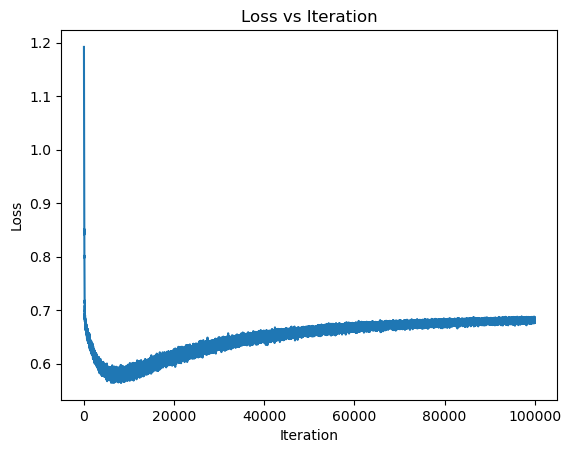

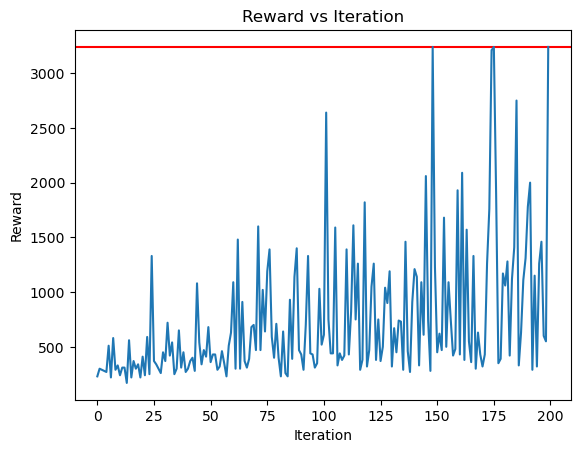

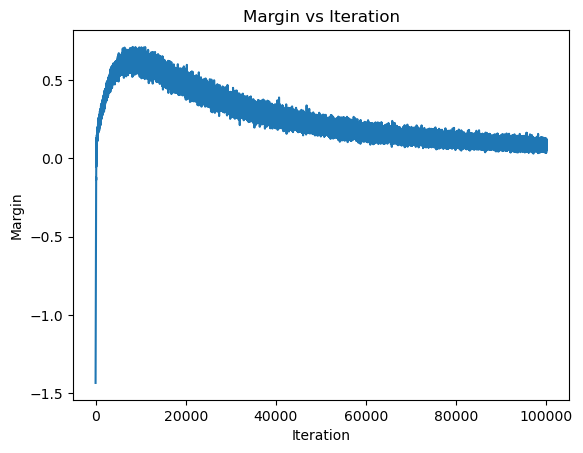

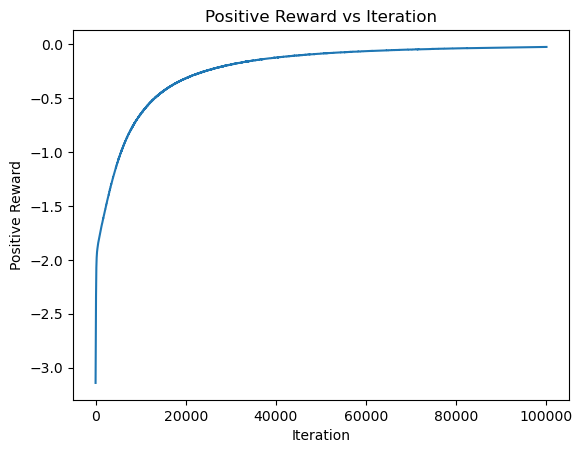

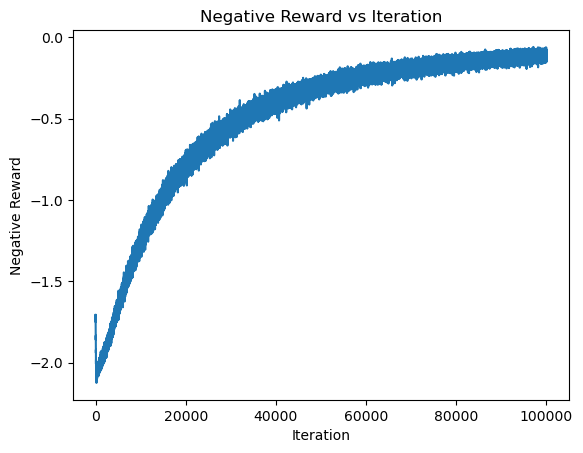

In [ ]:
# save all png to /mnt/nfs/work/albertliu/RL/CartPole-v1/DPO

# draw the loss graph
import matplotlib.pyplot as plt
plt.plot(loss_graph)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss vs Iteration")
plt.savefig("./loss.png")

plt.show()



# draw the reward graph
# draw a horizontal line at y=3240 which is the expert reward
plt.axhline(y=3240, color='r', linestyle='-', label="Expert Reward")
plt.plot(eval_rewards)
plt.xlabel("Iteration")
plt.ylabel("Reward")
plt.title("Reward vs Iteration")
plt.savefig("./reward.png")
plt.show()

# drqw the margin graph
plt.plot(margin_graph)
plt.xlabel("Iteration")
plt.ylabel("Margin")
plt.title("Margin vs Iteration")
plt.savefig("./margin.png")

plt.show()

# draw the positive reward graph
plt.plot(positive_reward_graph)
plt.xlabel("Iteration")
plt.ylabel("Positive Reward")
plt.title("Positive Reward vs Iteration")
plt.savefig("./positive_reward.png")
plt.show()

# draw the negative reward graph
plt.plot(negative_reward_graph)
plt.xlabel("Iteration")
plt.ylabel("Negative Reward")
plt.title("Negative Reward vs Iteration")

plt.savefig("./negative_reward.png")
plt.show()


In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# img = mpimg.imread("/mnt/nfs/work/albertliu/RL/CartPole-v1/dataset/"+env_id+"_28000_rewards.png")
# plt.imshow(img)
# plt.show()